# Test outputting the light curves

In [1]:
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
import csv
import os
import pandas as pd
import pickle

import sys
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from OpSim import OpSim
from newLSSTEBWorker import LSSTEBWorker 

from matplotlib import pyplot as plt
#%matplotlib notebook
%matplotlib inline

# this is horribly slow
# %load_ext autoreload
# %autoreload 2

/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))
/Users/ageller/anaconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:2286: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


## Pick an OpSim field

In [2]:
filters = ['u_', 'g_', 'r_', 'i_', 'z_', 'y_']

In [3]:
OpS = OpSim()
OpS.dbFile = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/db/baseline2018a.db'
OpS.getAllOpSimFields()

getting OpSim fields...
have summary cursor.
have field cursor.
returned 5292 fields


914.0


/Users/ageller/anaconda3/lib/python3.7/site-packages/matplotlib/projections/geo.py:414: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


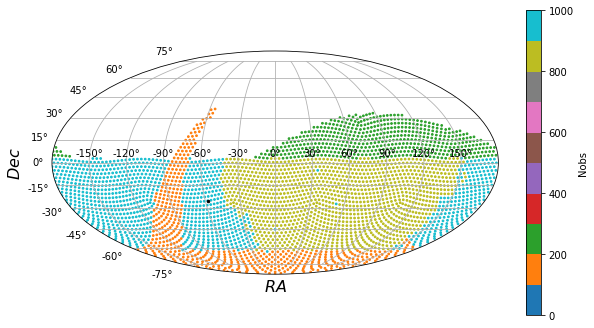

In [4]:
coords = SkyCoord(OpS.RA, OpS.Dec, unit=(u.degree, u.degree),frame='icrs')
lGal = coords.galactic.l.wrap_at(180.*u.degree).degree
bGal = coords.galactic.b.wrap_at(180.*u.degree).degree

raGal = coords.icrs.ra.wrap_at(180.*u.degree).degree
decGal = coords.icrs.dec.wrap_at(180.*u.degree).degree


f, ax = plt.subplots(subplot_kw={'projection': "mollweide"}, figsize=(10,8))
ax.grid(True)
ax.set_xlabel(r"$RA$",fontsize=16)
ax.set_ylabel(r"$Dec$",fontsize=16)
xx = np.where(OpS.Nobs > 0)
mlw = ax.scatter(raGal[xx]*np.pi/180.,decGal[xx]*np.pi/180., s = 3, c=OpS.Nobs[xx], cmap='tab10', alpha = 1, vmin=0, vmax=1000)
cbar = f.colorbar(mlw, shrink=0.7)
cbar.set_label(r'Nobs')
    
#choose some number
OpSimi = 1520
print(OpS.Nobs[OpSimi])
ax.scatter([raGal[OpSimi]*np.pi/180.],[decGal[OpSimi]*np.pi/180.], s = 6, c='black')


In [5]:
OpS.setDates(OpSimi, filters)

*The stuff above takes a while to run because of getting OpSim.*

## Set up the worker and get the Galaxy model

In [6]:
worker = LSSTEBWorker()
worker.OpSim = OpS
worker.filterFilesRoot = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/filters/'
#worker.initialize(OpSimi) #this just sets the dates, but I already did that above

In [7]:
galDir = 'grid'
if not os.path.exists(galDir):
    os.makedirs(galDir)
worker.galDir = galDir
worker.getGalaxy(OpSimi, deleteModel = False, downloadModel = False) #already downloaded this one

downloaded TRILEGAL model for ID=1521.0, RA=302.03318, DEC=-25.29462, Nstars=377029.0, Nstars/resEl=0.0005937090576971529


In [8]:
print(worker.Galaxy.model.sample())

        Gc  logAge  [M/H]    m_ini   logL  logTe   logg  m-M0     Av  m2/m1  \
226451   2   10.07  -1.29  0.28744 -1.718   3.62  5.039  12.6  0.286    0.0   

          mbol  u_mag   g_mag   r_mag   i_mag   z_mag   Y_mag   Mact  logDist  
226451  21.665  25.56  23.278  22.149  21.668  21.419  21.276  0.287     0.52  


### Set up the output file

In [9]:
def writeLine(csvwriter, EB, LCfile):
    output = [EB.period, EB.m1, EB.m2, EB.r1, EB.r2, EB.eccentricity, EB.inclination, EB.dist, EB.nobs, 
              EB.AV, EB.M_H, EB.appMagMean['r_'], EB.maxDeltaMag, EB.deltaMag['r_'], EB.eclipseDepthFrac['r_'],
              EB.appmag_failed, EB.incl_failed, EB.period_failed, EB.radius_failed, EB.eclipseDepth_failed]
    
    #this is for gatspy
    for filt in filters:
        output.append(EB.LSS[filt]) 
    output.append(EB.LSM) 
    output.append(LCfile)
        
    csvwriter.writerow(output)

## Sample from the galaxy to get the binaries

In [10]:
#open the file and write the header
summaryFile = 'LC/summary_OpSim' + str(OpSimi).zfill(4) + '.csv'
csvfile = open(summaryFile, 'w')
csvwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
cols = ['p', 'm1', 'm2', 'r1', 'r2', 'e', 'i', 'd', 'nobs',
        'Av','[M/H]','appMagMean_r', 'maxDeltaMag', 'deltaMag_r','eclipseDepthFrac_r',
        'mag_failure', 'incl_failure', 'period_failure', 'radius_failure', 'eclipseDepth_failure',
        'u_LSS_PERIOD', 'g_LSS_PERIOD', 'r_LSS_PERIOD', 'i_LSS_PERIOD', 'z_LSS_PERIOD', 'y_LSS_PERIOD', 'LSM_PERIOD',
        'LC_file']
csvwriter.writerow(cols)    


nOut = 10 #number of EBs that I want to output
nFinished = 0

worker.magLims = [15.8, 19.5] #prsa limits
worker.eclipseDepthLim = 3. #depth / error
    
while nFinished < nOut:
    s = worker.Galaxy.model.sample()
    binary = worker.makeBinaryFromGalaxy(s)
    line = np.array([binary['m1'], 
            binary['m2'],
            binary['logp'],
            binary['ecc'],
            binary['rad1'],
            binary['rad2'],
            binary['lum1'],
            binary['lum2'], 
            0, 0, 0, 
            binary['dist'],
            binary['inc'],
            binary['OMEGA'],
            binary['omega'],
            binary['Av'],
            binary['MH'],
            binary['teff1'],
            binary['teff2'],
            binary['logg1'],
            binary['logg2'],
            binary['rmag']])

    worker.getEB(line, OpSimi=OpSimi)
    fname = None
    if (worker.EB.observable):
        worker.run_ellc(0) 
        print('observable in mag', worker.EB.eclipseDepthFrac)
        if (worker.EB.observable):
            worker.run_gatspy(0)
            fname = 'LC/ellc_OpSim' + str(OpSimi).zfill(4) + '_' + str(nFinished).zfill(4)+'.pickle'
            worker.EB.outputLCtoFile(fname)
            nFinished += 1
            print('observable in eclipse', nFinished)

    writeLine(csvwriter, worker.EB, fname)
    
csvfile.close()

observable in mag {'u_': <Quantity 1.92551587>, 'g_': <Quantity 13.03039003>, 'r_': <Quantity 15.47432959>, 'i_': <Quantity 7.68418373>, 'z_': <Quantity 9.06015378>, 'y_': <Quantity 3.53709977>}
observable in eclipse 1
observable in mag {'u_': <Quantity 1.43497436>, 'g_': <Quantity 3.51156056>, 'r_': <Quantity 1.77338076>, 'i_': <Quantity 1.80192875>, 'z_': <Quantity 2.80098095>, 'y_': <Quantity 2.6992757>}
observable in mag {'u_': <Quantity 1.27515609>, 'g_': <Quantity 5.40136783>, 'r_': <Quantity 9.41953712>, 'i_': <Quantity 6.3237243>, 'z_': <Quantity 5.40943727>, 'y_': <Quantity 8.35070816>}
observable in eclipse 2
observable in mag {'u_': <Quantity 1.81906018>, 'g_': <Quantity 2.91884867>, 'r_': <Quantity 2.63921703>, 'i_': <Quantity 2.94788307>, 'z_': <Quantity 2.426032>, 'y_': <Quantity 3.08022941>}
observable in mag {'u_': <Quantity 3.61456233>, 'g_': <Quantity 8.74417135>, 'r_': <Quantity 12.43665365>, 'i_': <Quantity 7.67179322>, 'z_': <Quantity 3.96417999>, 'y_': <Quantity 7

## Test the output files

In [11]:
summary = pd.read_csv(summaryFile)
summary

,p,m1,m2,r1,r2,e,i,d,nobs,Av,...,radius_failure,eclipseDepth_failure,u_LSS_PERIOD,g_LSS_PERIOD,r_LSS_PERIOD,i_LSS_PERIOD,z_LSS_PERIOD,y_LSS_PERIOD,LSM_PERIOD,LC_file
0,162.443942,0.628,0.053,0.584136,0.243878,0.066283,44.084076,12.589254,0,0.320,...,0,0,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,NaN
1,95.598567,0.372,0.337,0.325316,0.301543,0.257264,109.284990,1.659587,0,0.331,...,0,0,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,NaN
2,745.122970,0.800,0.576,1.008275,0.522090,0.702203,12.573115,13.803843,0,0.373,...,0,0,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,NaN
3,894.190845,0.453,0.132,0.395442,0.152869,0.448412,139.871213,5.248075,0,0.342,...,0,0,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,NaN
4,335.982952,0.591,0.542,0.548691,0.493212,0.968424,131.300595,8.709636,0,0.421,...,0,0,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,NaN
5,3249.760849,0.861,0.845,3.206531,1.438673,0.760561,109.487270,4.168694,0,0.390,...,0,0,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,NaN
6,82.863701,0.488,0.457,0.419511,0.407373,0.686254,78.266168,12.589254,0,0.353,...,0,0,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,NaN
7,3058.371580,0.231,0.033,0.240071,0.239492,0.437920,91.930389,0.575440,0,0.289,...,0,0,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,NaN
8,1417.949527,0.447,0.216,0.403820,0.215656,0.393695,57.730080,3.162278,0,0.331,...,0,0,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,NaN
9,151.802541,0.242,0.238,0.237652,0.233788,0.133425,82.173127,1.096478,0,0.390,...,0,0,-999.000000,-999.00000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,NaN


Text(0.5, 0, 'q')

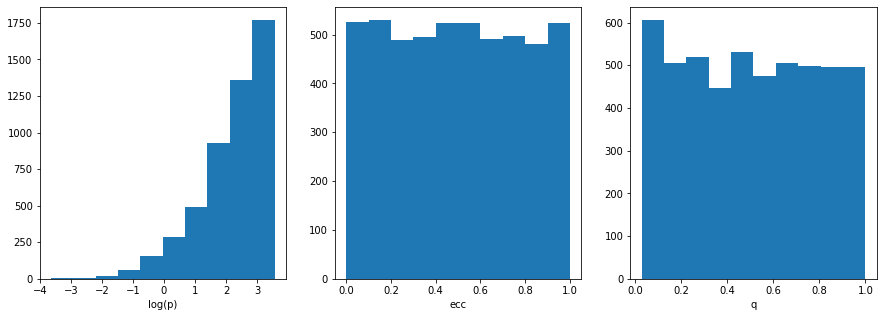

In [12]:
f,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
_ = ax1.hist(np.log10(summary['p']))
ax1.set_xlabel('log(p)')

_ = ax2.hist(summary['e'])
ax2.set_xlabel('ecc')

_ = ax3.hist(summary['m2']/summary['m1'])
ax3.set_xlabel('q')

3.5978849134892843 0.750007139512393 0.5000142790247859 0.8750035697561964
0.3124884648155263 0.271824566447508 0.456350867104984 0.635912283223754
0.4273619749028982 0.5000007747417219 1.549483443725859e-06 0.7500003873708609
9.110147097680377 0.9692198422664104 0.9384396845328207 0.9846099211332051
2.7453948540881936 0.7790978787217224 0.5581957574434446 0.8895489393608611
0.9020553288401552 0.6666680251424342 0.3333360502848683 0.8333340125712171
1.033611455907856 0.4999997503956812 4.992086376236939e-07 0.7499998751978406
1.5447559224977367 0.7499990590682769 0.49999811813655387 0.8749995295341385
19.775741391909836 0.9886122783167847 0.9772245566335693 0.9943061391583924
0.5340815638970855 0.49999955717869615 8.856426076879706e-07 0.7499997785893481
rec/obs*100. =  30.0


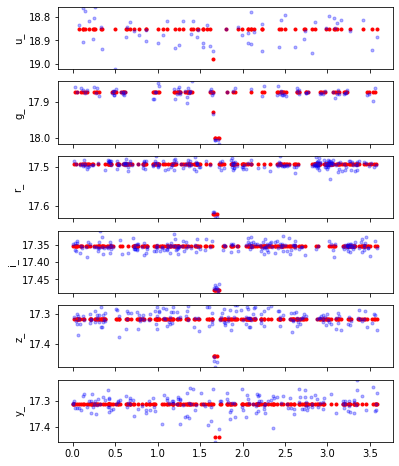

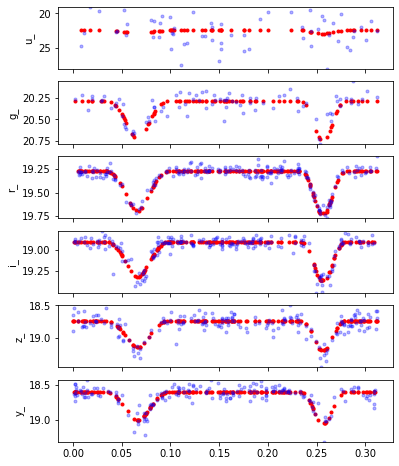

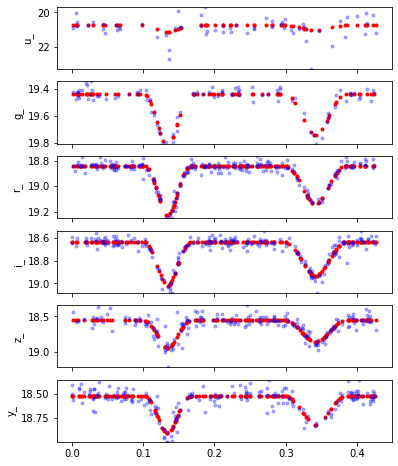

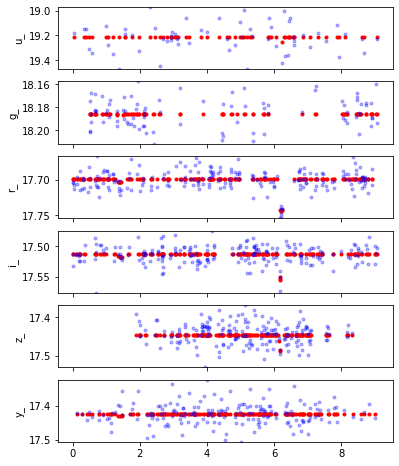

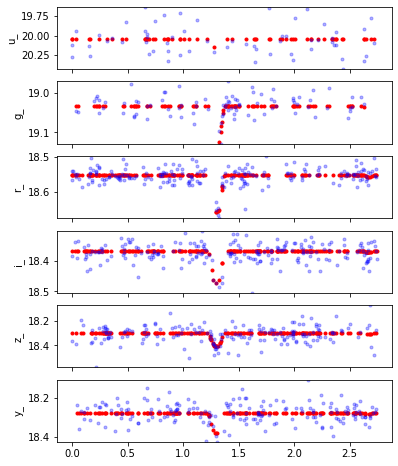

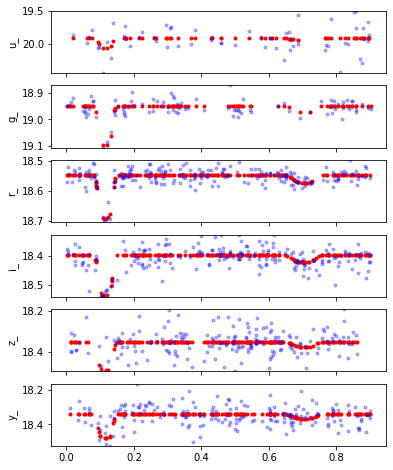

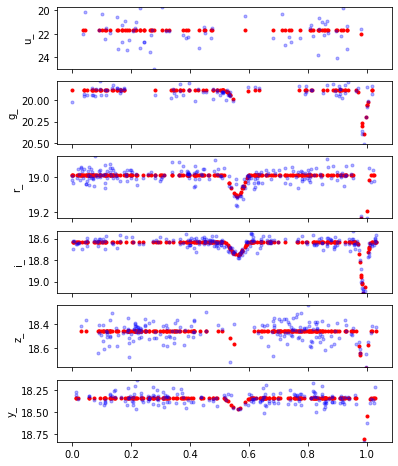

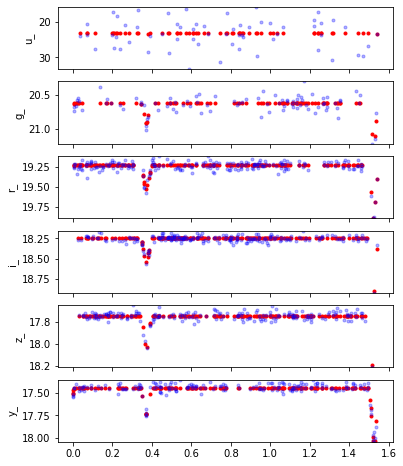

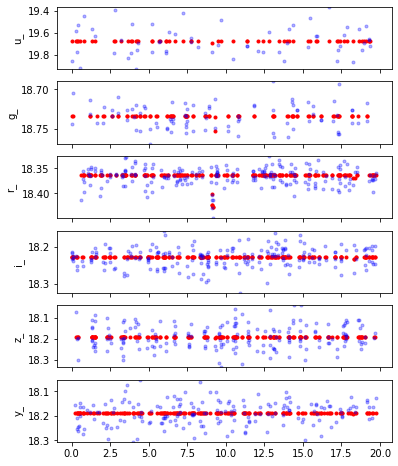

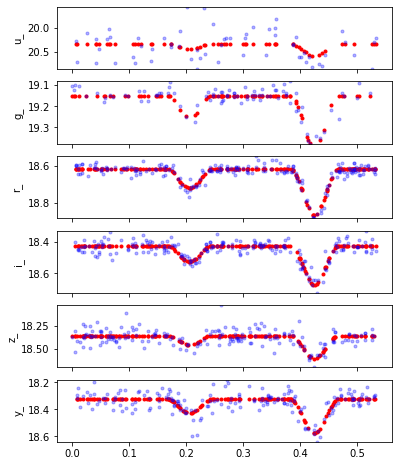

In [13]:
plim = 0.1
obs = 0
rec = 0
for index, row in summary.iterrows():
    if (not pd.isna(row['LC_file'])):
        obs += 1
        #print(row)
        key = 'LSM_PERIOD'
        fullP = abs(row[key] - row['p'])/row['p']
        halfP = abs(row[key] - 0.5*row['p'])/(0.5*row['p'])
        twiceP = abs(row[key] - 2.*row['p'])/(2.*row['p'])
        print(row['p'], fullP, halfP, twiceP)
        if (fullP < plim or halfP < plim or twiceP < plim):
            rec += 1
        
        file = open(row['LC_file'], 'rb')
        lc = pickle.load(file)
        file.close()
        fig,ax = plt.subplots(6,1, figsize=(6,8), sharex = True)
        for i,f in enumerate(filters):
            ax[i].plot((lc[f]['OpSimDates'] % row['p']), lc[f]['mag'],'.', color='red')
            ax[i].plot((lc[f]['OpSimDates'] % row['p']), lc[f]['magObs'],'.', alpha=0.3, color='blue')
            ax[i].set_ylim(max(lc[f]['magObs']), min(lc[f]['magObs']))
            ax[i].set_ylabel(f)
print("rec/obs*100. = ", rec/obs*100.)